Let's create a predictive model for stock prices using the data for Johnson & Johnson company

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [2]:
import tensorflow as tf

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

Downloading data from https://www.marketwatch.com/investing/stock/jnj/download-data, and reading csv file

In [4]:
jnj_complete = pd.read_csv(r'JNJ.csv')

40 rows from the tail of table are used for testing.

In [5]:
data_split_point = 40

Split on September, 01, 2023

In [6]:
import datetime as dt
import matplotlib.dates as mdates

dates_arr = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in jnj_complete['Date']]

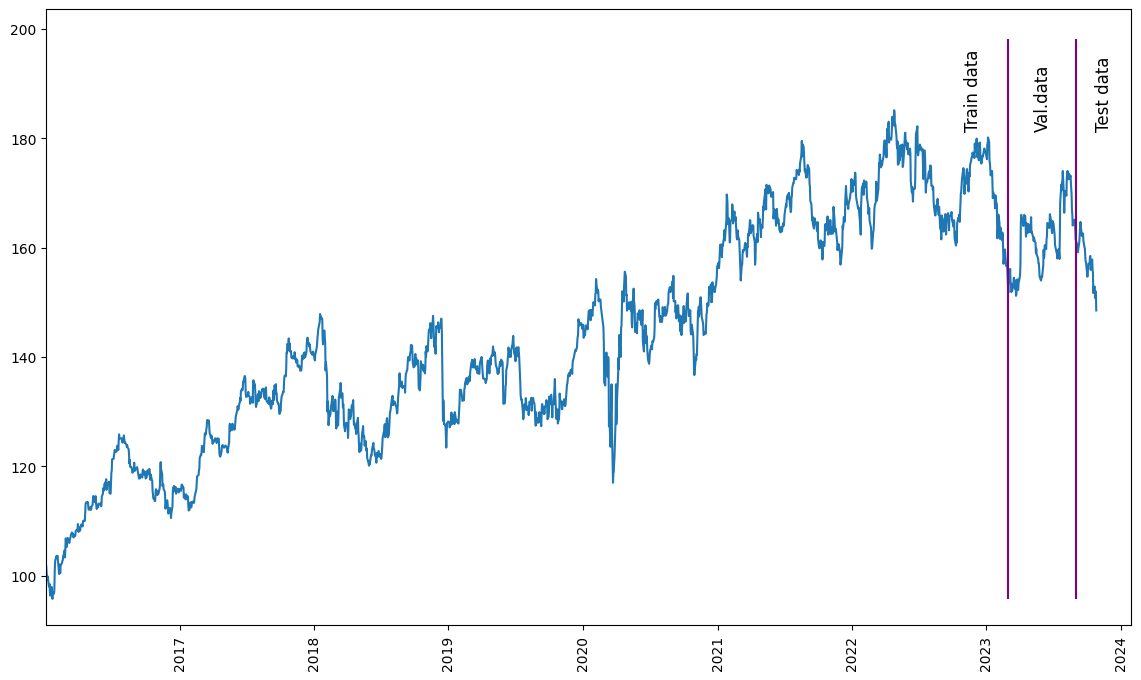

In [7]:
fig = plt.figure(figsize=(14, 8))


plt.text(dates_arr[1850], 182, 'Val.data', fontsize = 12, rotation = 90)
plt.text(dates_arr[1965], 182, 'Test data', fontsize = 12, rotation = 90)
plt.text(dates_arr[1720], 182, 'Train data', fontsize = 12, rotation = 90)
plt.xlim(dates_arr[0], dt.datetime.strptime('2024-01-30','%Y-%m-%d').date())
plt.ylim(jnj_complete['Open'].min()*0.95, jnj_complete['Open'].max()*1.1)

plt.plot(dates_arr, jnj_complete['Open'])
plt.xticks(rotation=90)
plt.vlines(x=dates_arr[-data_split_point], ymin=jnj_complete['Open'].min(), ymax =jnj_complete['Open'].max()*1.07, colors='purple')

plt.vlines(x=dates_arr[1800], ymin=jnj_complete['Open'].min(), ymax =jnj_complete['Open'].max()*1.07, colors='purple')

plt.show()



Let's read data as shown on the picture above


In [8]:
jnj_processed = jnj_complete.iloc[:, 1:2].values

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))

jnj_scaled = scaler.fit_transform(jnj_processed)

In [9]:
len(jnj_scaled)

1969

In [10]:
delay = 60
data_split_point = 40
train_ds_size = 1800
b_size = 32

The datasets were created from the full data from file.

In [11]:
keras_ts_train = tf.keras.utils.timeseries_dataset_from_array(
    data=jnj_scaled,
    targets=jnj_scaled[delay:],
    sequence_length=delay,
    batch_size = b_size,
    start_index = 0,
    end_index = train_ds_size + delay-1)

2024-02-09 20:41:57.682288: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-02-09 20:41:57.682371: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-02-09 20:41:57.682392: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-02-09 20:41:57.682523: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-09 20:41:57.682585: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [12]:
keras_ts_val = tf.keras.utils.timeseries_dataset_from_array(
    data=jnj_scaled,
    targets=jnj_scaled[delay:],
    sequence_length=delay,
    batch_size = b_size,
    start_index = train_ds_size,
    end_index = len(jnj_scaled) - data_split_point-1)

In [13]:
keras_ts_test = tf.keras.utils.timeseries_dataset_from_array(
    data=jnj_scaled,
    targets=jnj_scaled[delay:],
    sequence_length=delay,
    batch_size = b_size,
    start_index=len(jnj_scaled)-data_split_point-delay,
    end_index=len(jnj_scaled)-1)

We got 3 datasets, they can be compared to the previous using the function below. They match exactly. 

In [14]:
### for implementing this function batch size has to be switched to 1

#!pip install tensorflow_datasets
'''import tensorflow_datasets as tfds
np_ds = tfds.as_numpy(keras_ts_train) ###  or keras_ts_train, keras_ts_test

fts = []
lbs = []
for f, l in np_ds:
    fts.append(f)
    lbs.append(l)

fts = np.array(fts)
lbs = np.array(lbs)
fts = fts.reshape((1800, 60, 1)) ### for val data change 1800->69, for test 1800->40
lbs = lbs.reshape((1800,)) ### for train data change 1800->69, for test 1800->40

print((lbs - train_labels).max(), (lbs - train_labels).min()) ### or val_labels or test_labels
print((fts - train_set).max(), (fts - train_set).min()) ### or val_set or test_features'''

'import tensorflow_datasets as tfds\nnp_ds = tfds.as_numpy(keras_ts_train) ###  or keras_ts_train, keras_ts_test\n\nfts = []\nlbs = []\nfor f, l in np_ds:\n    fts.append(f)\n    lbs.append(l)\n\nfts = np.array(fts)\nlbs = np.array(lbs)\nfts = fts.reshape((1800, 60, 1)) ### for val data change 1800->69, for test 1800->40\nlbs = lbs.reshape((1800,)) ### for train data change 1800->69, for test 1800->40\n\nprint((lbs - train_labels).max(), (lbs - train_labels).min()) ### or val_labels or test_labels\nprint((fts - train_set).max(), (fts - train_set).min()) ### or val_set or test_features'

We got 0 difference for data while using timeseries_dataset_from_array and manually defining the data.

### Creating and fitting the model

In [15]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(delay, 1),unroll=False))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units = 1))

In [16]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

In [17]:
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(keras_ts_train,
                    epochs=100,
                    callbacks = [callback],
                    verbose = 0,
                    validation_data=keras_ts_val)

2024-02-09 20:42:11.886372: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


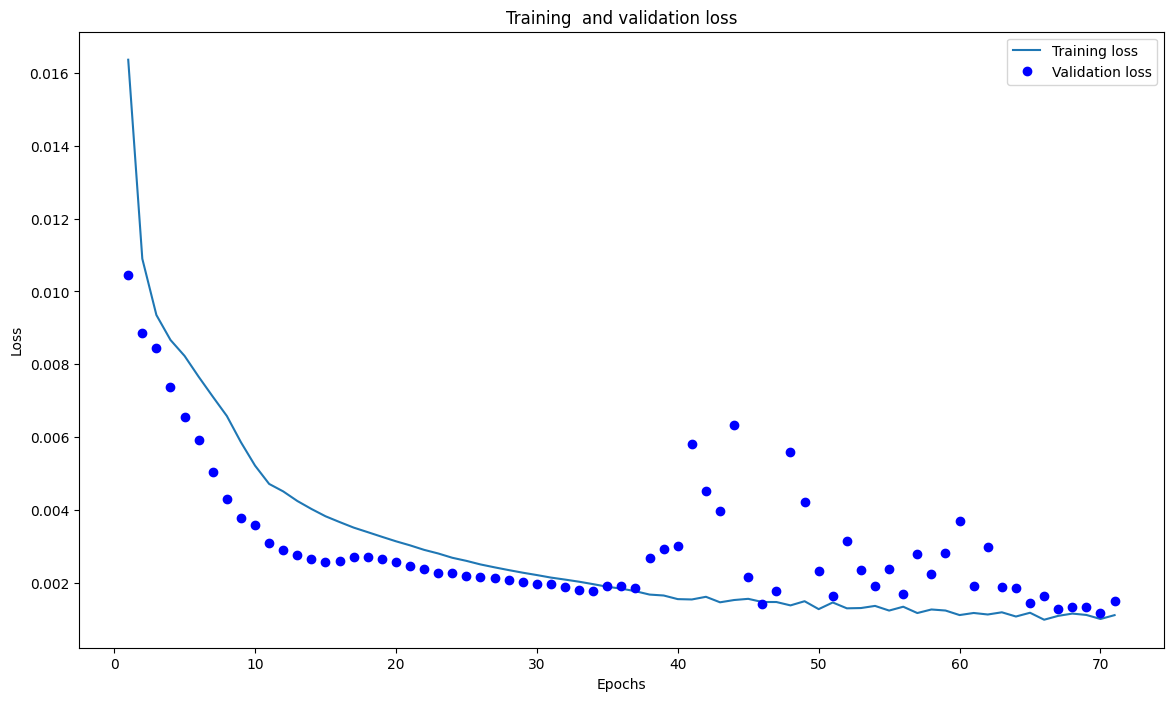

In [18]:
import matplotlib.pyplot as plt

loss = history.history['loss']

val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

fig = plt.figure(figsize=(14,8))
# "bo" is for "blue dot"
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, 'bo' , label='Validation loss')
plt.title('Training  and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


Though the datasets are almost the same (though they were created using different approaches), the loss value is about 5 times higher. Model converges worse. 
Let's check out predictions.

In [19]:
predictions = model.predict(keras_ts_test)

2/2 [==============================] - 1s 55ms/step


In [20]:
predictions = scaler.inverse_transform(predictions)

In [21]:
jnj_test_ = jnj_complete[-data_split_point:]['Open'].values

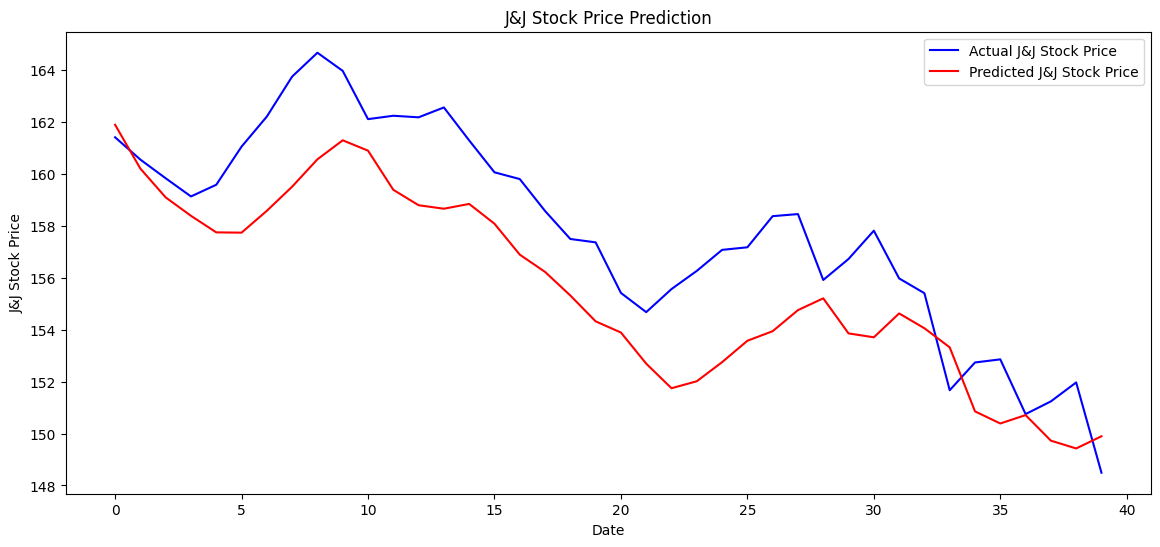

In [22]:
plt.figure(figsize=(14,6))
plt.plot(jnj_test_, color='blue', label='Actual J&J Stock Price')
plt.plot(predictions , color='red', label='Predicted J&J Stock Price')
plt.title('J&J Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('J&J Stock Price')
plt.legend()
plt.show()

Model predictions are close enough to the testing data. Though the predictions are not perfect, the curve shows the overall trend. Though we see some delays when the trend changes.